In [64]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from codes.solvers import solver
from codes.tb import transforms, utils
from codes.model import Model
import codes.model
from codes.tb.tb import add_tb, scale_tb
from codes import mf
from codes import observables
import codes.tb.transforms


In [65]:
def old_total_energy(h, rho):
    """
    Compute total energy.

    Paramters:
    ----------
    h : nd-array
        Hamiltonian.
    rho : nd-array
        Density matrix.

    Returns:
    --------
    total_energy : float
        System total energy computed as tr[h@rho].
    """
    return np.sum(np.trace(h @ rho, axis1=-1, axis2=-2)).real / np.prod(rho.shape[:-2])


In [66]:
def total_energy(ham_tb, rho_tb): 
    return np.real(observables.expectation_value(rho_tb, ham_tb))


In [67]:
U0 = 1
filling = 2

hopp = np.kron(np.array([[0, 1], [0, 0]]), np.eye(2))
h_0 = {(0,): hopp + hopp.T.conj(), (1,): hopp, (-1,): hopp.T.conj()}
h_int_U0 = {
        (0,): U0 * np.kron(np.eye(2), np.ones((2, 2))),
    }


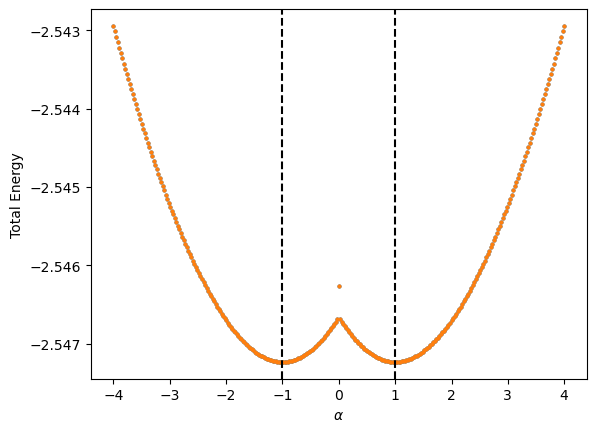

In [70]:
nk = 100
guess = utils.generate_guess(frozenset(h_int_U0), len(h_int_U0[(0,)]))

_model = Model(h_0, h_int_U0, filling=filling)
mf_sol_groundstate = solver(_model, mf_guess=guess, nk=nk, optimizer_kwargs={"M": 0})

@np.vectorize
def mfRescaled(alpha, mf0=mf_sol_groundstate):
    hamiltonian = add_tb(h_0, scale_tb(mf0,alpha))
    rho, _ = codes.model.rho(hamiltonian, filling=filling, nk=nk, ndim=1)
    hamiltonian = add_tb(h_0, scale_tb(mf0, np.sign(alpha)))

    hamiltonian_k = transforms.tb_to_khamvector(hamiltonian, nk, ndim=1)
    rho_k = transforms.tb_to_khamvector(rho, nk, ndim=1)
    #return total_energy(hamiltonian, rho)
    return old_total_energy(hamiltonian_k, rho_k)

alphas = np.linspace(-4, 4, 301)
plt.plot(alphas, mfRescaled(alphas), 'o', ms=2)
plt.plot(-alphas, mfRescaled(alphas), 'o', ms=2)
plt.axvline(x=1, c="k", ls="--")
plt.axvline(x=-1, c="k", ls="--")
plt.ylabel("Total Energy")
plt.xlabel(r"$\alpha$")
# plt.ylim(-4.6, -4.5)
plt.show()

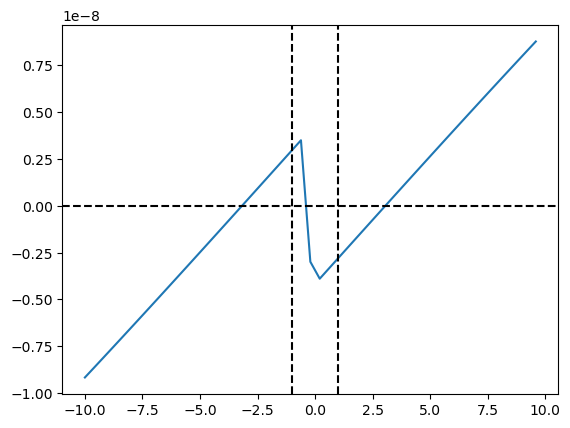

In [45]:
plt.plot(alphas[:-1], np.diff(mfRescaled(alphas)))
# plt.plot(-alphas[:-1], -np.diff(mfRescaled(alphas)))
plt.axhline(0, ls='--', c='k')
plt.axvline(x=1, c="k", ls="--")
plt.axvline(x=-1, c="k", ls="--")
# plt.ylim(-4, -2)
plt.show()